$$\require{mhchem}$$

# In class assignment (6 pts)

Complete the in-class assignment that you started in class on Wednesday. Since the solutions are already available, this will simply be graded for completeness. 

 We have a liquid feed of A and B, with concentration of A 2M and concentration of B 3M, with a total flow rate of 0.1 m$^3$/s.  We are looking to optimize the conversion of the reaction: 
\begin{align*}
\ce{A + 2B -> C}
\end{align*}
You can assume in all cases the reaction is isothermal and the volume does not change with changes in the molar flow rates of the reactants.  The reaction is elementary and the rate constant is $k_1=0.1 dm^6/mol^2/s$



## First, find the maximum extent of reaction $\xi^{max}$ and write the rate equation $r$. (5 pts)

Since we have a constant volume reactor and a constant volumetric flow, we use an intensive reaction extent:

\begin{equation}
C_j = C_{j, 0} + \alpha_j \xi
\end{equation}

To find maximum reaction extent, we set $C_j=0$ to zero, yielding:

\begin{equation}
\xi_{max} = \underset{\in\, positive,\, non-zero}{min}\{-C_{j, 0} / \alpha_j\}
\end{equation}

In [1]:
import numpy as np

Ca0 = 2.         # mol/L
Cb0 = 3.         # mol/L
C0 = np.array([Ca0, Cb0])
alpha = np.array([-1, -2]) # stoichiometric coefficients

xis = -C0/alpha
xi_max = min([xi for xi in xis if xi > 0])

print('The maximum extent of reaction is %.2f mol/L' % xi_max)

The maximum extent of reaction is 1.50 mol/L


$$r=kC_{a}C_{b}^{2}$$

## Now, find the extent of reaction for a steady state 100 L CSTR with the feed and flow rate from above. (10 pts)
<img src="E1P1B.png" alt="Drawing" style="width: 300px;"/>


In [4]:
from scipy.optimize import fsolve

nu = 0.1*1000  # L/s
k1 = 0.1       # L^2/mol^2/s
V = 100.       # L

def dXdt(C):
    ''' Create a function to calculate the change in moles of species over time '''
    Ca, Cb = C                           # mol/L
    r = k1*Ca*Cb**2.                     # mol/L/s
    dAdt = (Ca0-Ca)*nu + alpha[0]*r*V    # mol/s
    dBdt = (Cb0-Cb)*nu + alpha[1]*r*V    # mol/s
    return [dAdt, dBdt]

# At steady-state, changes in concentration will all be zero. `fsolve` will find this steady-state for us
C = fsolve(dXdt, [Ca0, Cb0])

# We modify the first equation we described in Part 1 to calculate the extent of reaction
xi = (C[0] - Ca0)/alpha[0]
print('The extent of reaction at steady-state is %.2f mol/L' % xi)

The extent of reaction at steady-state is 0.54 mol/L


## Find the final extent of reaction for a 100 L PFR (10 pts)
<img src="E1P1C.png" alt="Drawing" style="width: 300px;"/>


In [5]:
from scipy.integrate import odeint

def dCdV(C, V):
    ''' Create a function to calculate the change in species concentrations over the change in reactor volume '''
    Ca, Cb = C         # mol/L
    r = k1*Ca*Cb**2.   # mol/L/s
    dCadV = alpha[0]*r/nu
    dCbdV = alpha[1]*r/nu
    return [dCadV, dCbdV]

# Use `odeint` to integrate the concentration profile over volume
V = 100.   # L
Vspan = [0, V]
C = odeint(dCdV, C0, Vspan)

# Use the same equation as before to calculate the extent of reaction
xi = (C[-1, 0] - Ca0)/alpha[0]
print('The extent of reaction at the outlet is %.2f mol/L' % xi)

The extent of reaction at the outlet is 0.72 mol/L


## Our operators tell us that they really like working with CSTR's and suggest that you use several CSTR's in series.  The total volume of CSTR's should equal 100 L.  For example, if you have 4 CSTR's, then  each will have a volume of 25 L.  The outflow of each CSTR is the same as the inflow to the next CSTR.  The extent of reaction for each reactor can be solved based on the extent of reaction from the previous reactor (sequentially).  Calculate the extent of reaction for the four reactor situation. (20 pts)
<img src="E1P1D.png" alt="Drawing" style="width: 500px;"/>


In [8]:
import matplotlib.pyplot as plt

def extent(N):
    ''' Create a function that calculates the extent of reaction given the number of CSTRs to use '''
    # Calculate the per-reactor volume, `v`
    v = V/N   # L
    
    def dXdt(array_in, xi_in):
        '''
        We will be using `fsolve` to calculate the extent of reaction at the outlet of each CSTR, and
        so we used `xi` as a function argument.
        
        On of our constraint is that the systems are at steady-state,
        and so we use fsolve to ensure that the changes in species counts per time are zero.
        Another constraint is that we already know the extent of reaction at the inlet, since that
        is governed by the previous reactor.
        '''
        # `fsolve` assumes that everything is a vector. We unpack the extent of reaction here
        # so that we can treat it as a float
        
        #2018 edit: fsolve now requires that the length of the input 
        # vector match the length of the output vector. So, we will only
        # use the first element in the input array. The second element will 
        # not matter.
        xi_out = array_in[0]
        
        # Calculate the inlet concentrations and the outlet concentrations [mol/L]
        Ca_in = Ca0 + alpha[0]*xi_in
        Cb_in = Cb0 + alpha[1]*xi_in
        Ca = Ca0 + alpha[0]*xi_out
        Cb = Cb0 + alpha[1]*xi_out
        # Use these concentrations to calculate the reaction rate [mol/L/s]
        r = k1*Ca*Cb**2.
        # Use both the reaction rate and flow streams to calculate the differentials [mol/s]
        dAdt = (Ca_in-Ca)*nu + alpha[0]*r*v
        dBdt = (Cb_in-Cb)*nu + alpha[1]*r*v

        return [dAdt, dBdt]
    
    # Solve the first reactor manually to initialize the iterations. Note that the second
    # argument to `fsolve` is our initial guess, while the third argument is our setting
    # for the extent of reaction at the inlet
    
    #2018 edit: Our initial guess for xi_out is 0.3. We make it a length-2
    # array so that fsolve is happy with length-2 input and output. 
    # the second unpacked value, discard, isn't used.
    xi, discard = fsolve(dXdt, [0.3,0], 0)
    
    # Our output, `xi_out`, will be a list of the extents of reactions at the outlet of each
    # of the reactors. We initialize that list here.
    xi_out = [xi]
    
    # Iterate through the remaining reactors and store the results in our output, `xi_out`
    for i in range(N-1):
        xi,b = fsolve(dXdt, [xi_out[-1],0], xi_out[-1])
        xi_out += [xi]

    return xi_out

print('The extent of reaction after 4 CSTRs in series is %.2f mol/L' % extent(4)[-1])

The extent of reaction after 4 CSTRs in series is 0.66 mol/L


## Plot the final extent of reaction for this approach from 1 to 10 reactors, and compare to the conversions from the CSTR and PFR examples above. (9 pts)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


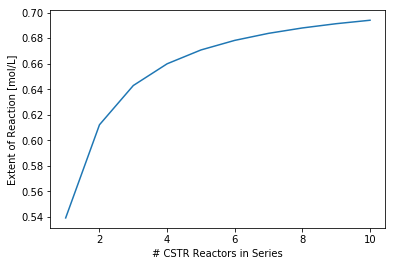

In [9]:
Nrange = range(1, 11)
extent_out = [extent(N)[-1] for N in Nrange]

plt.plot(Nrange, extent_out)
plt.xlabel('# CSTR Reactors in Series')
plt.ylabel('Extent of Reaction [mol/L]')
plt.show()

## We are considering adding a membrane to the PFR.  We have a few options.  For each, answer qualitatively if you think the conversion of A would increase, decrease, or stay the same, and why: (2 pts each)
- A membrane that allows A to be added slowly through the side of the PFR (w/ pure B inlet), total molar flow rate of A & B the same
- A membrane that allows B to be added slowly through the side of the PFR (w/ pure A inlet), total molar flow rate of A & B the same
- A membrane that allows C to be removed continuously through the side of the PDF

Answers:
1. This would decrease the conversion, because it would effectively reduce the reaction rates by reducing the inlet concentration of A.
2. This would decrease the conversion, because it would effectively reduce the reaction rates by reducing the inlet concentration of B.
3. This would not affect the reaction rate, because the addition or subtraction of the product does not affect the reaction rate of a non-reversible reaction... but since all real-world reactions are reversible (to some extent), we will also accept answers that claim that conversion will increase due to Le Chatelier's Principle.

# Science/python questions (2 pts)

There were some good questions during the in-class assignment on Wednesday. Post one question on Piazza on either reaction engineering or python questions.

# PFR with changing number of moles

## Consider the reaction $\ce{2A ->[k_1] 4B ->[k_2] C}$ in a 5 L PFR. Both reactions are elementary, $k_1=5$[1/M/min], $k_2=1000$[1/M$^3$/min] The inlet flow rate is 100% A at 10 bar and 500K. The initial flow rate is 1 [L/min]. Solve and plot the molar flow rates of each species. Assume the reactor is isothermal and isobaric, and all gases are ideal.

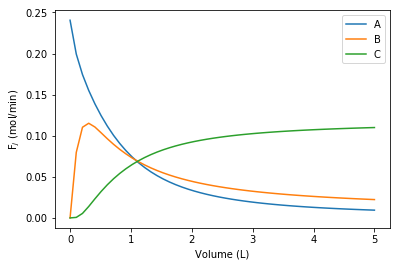

In [2]:
import numpy as np
from scipy.integrate import odeint
v0 = 1    # L / min
k1 = 5 # 1 / M / min
k2 = 1000 # 1/ M^3 / min
P = 10 # bar
T = 500 # K
R = 8.314e-2 # L bar / K / mol

Fa0 = P*v0/R/T
Ft0 = Fa0

def dFdV(F, V):

    Fa, Fb, Fc = F    # we only need Fa for the rate law
    Ft = sum(F)       # total flow rate
    v = v0 * Ft / Ft0

    Ca = Fa / v
    Cb = Fb / v

    r1 = k1 * Ca **2.
    r2 = k2 * Cb **4.
    ra = -2*r1
    rb = 4*r1 - 4*r2
    rc = r2

    dFadV = ra
    dFbdV = rb
    dFcdV = rc

    return [dFadV, dFbdV, dFcdV]


Vspan = np.linspace(0, 5)  # L

# Initial conditions, one for each ODE
F0 = [Fa0, 0, 0]

sol = odeint(dFdV, F0, Vspan)

import matplotlib.pyplot as plt
Fa = sol[:,0]
Fb = sol[:,1]
Fc = sol[:,2]

plt.plot(Vspan, Fa,
         Vspan, Fb,
         Vspan, Fc)

plt.xlabel('Volume (L)')
plt.ylabel('F$_j$ (mol/min)')

plt.legend(['A', 'B', 'C'])
plt.show()

## Plot the volumetric flow along the length of the reactor.

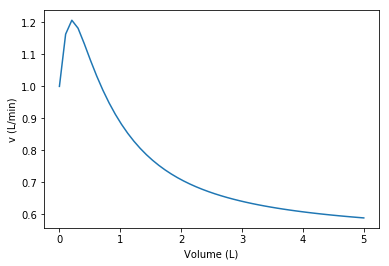

In [3]:
Fa = sol[:,0]
Fb = sol[:,1]
Fc = sol[:,2]
Ft = np.sum(sol, axis=1)       # total flow rate
v = v0 * Ft / Ft0

plt.plot(Vspan, v)

plt.xlabel('Volume (L)')
plt.ylabel('v (L/min)')

plt.show()

## Bonus (1 pt) Plot both 3.1 and 3.2 on the same graph, with molar flow rates on the left axis and the flow rate on the y-axis. Hint: one way to do this (among several, https://matplotlib.org/examples/api/two_scales.html)

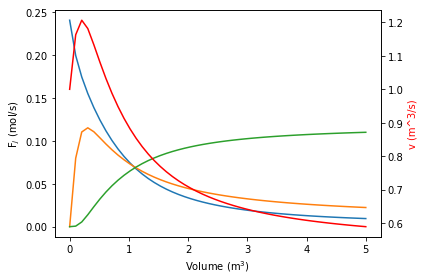

In [3]:
fig, ax1 = plt.subplots()

Fa = sol[:,0]
Fb = sol[:,1]
Fc = sol[:,2]

ax1.plot(Vspan, Fa,
         Vspan, Fb,
         Vspan, Fc)

ax1.set_xlabel('Volume (m$^3$)')
ax1.set_ylabel('F$_j$ (mol/s)')

ax2 = ax1.twinx()

Fa = sol[:,0]
Fb = sol[:,1]
Fc = sol[:,2]
Ft = np.sum(sol, axis=1)       # total flow rate
v = v0 * Ft / Ft0

plt.plot(Vspan, v, 'r')

ax2.set_ylabel('v (m^3/s)', color='r')

fig.tight_layout()
plt.show()

## Read through the rest of the lecture from Wednesday. Assuming the reactor is isothermal but has a pressure drop from a packed bed and $\alpha=0.2$[1/L], redo the calculations for the flow rates, volumetric flow rate, and pressure

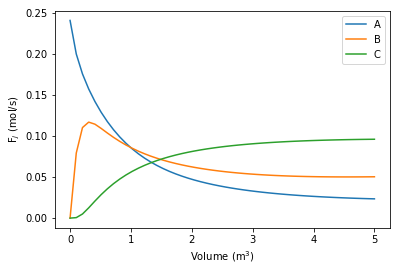

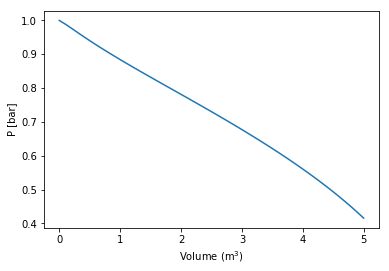

In [4]:
import numpy as np
from scipy.integrate import odeint
v0 = 1    # L / min
k1 = 5 # 1 / M / min
k2 = 1000 # 1/ M^3 / min
P0 = 10 # bar
T = 500 # K
R = 8.314e-2 # L bar / K / mol

Fa0 = P0*v0/R/T
Ft0 = Fa0

alpha = 0.2 #1/L

def dFdV(F, V):

    Fa, Fb, Fc, y = F    # we only need Fa for the rate law
    
    P = y*P0

    Ft = Fa + Fb + Fc # total flow rate
    v = v0 * Ft / Ft0 * P0 / P
    

    Ca = Fa / v
    Cb = Fb / v

    r1 = k1 * Ca **2.
    r2 = k2 * Cb **4.
    ra = -2*r1
    rb = 4*r1 - 4*r2
    rc = r2

    dFadV = ra
    dFbdV = rb
    dFcdV = rc
    
    dPdV = - alpha / 2 / y * Ft / Ft0

    return [dFadV, dFbdV, dFcdV, dPdV]


Vspan = np.linspace(0, 5)  # L

# Initial conditions, one for each ODE
F0 = [Fa0, 0, 0, 1]

sol = odeint(dFdV, F0, Vspan)

import matplotlib.pyplot as plt
Fa = sol[:,0]
Fb = sol[:,1]
Fcf = sol[:,2]

plt.plot(Vspan, Fa,
         Vspan, Fb,
         Vspan, Fcf)

plt.xlabel('Volume (m$^3$)')
plt.ylabel('F$_j$ (mol/s)')

plt.legend(['A', 'B', 'C'])
plt.show()

P = sol[:,3]

plt.plot(Vspan, P)

plt.xlabel('Volume (m$^3$)')
plt.ylabel('P [bar]')
plt.show()

## Make a plot compare the molar flow rate profile for C with and without the pressure drop.

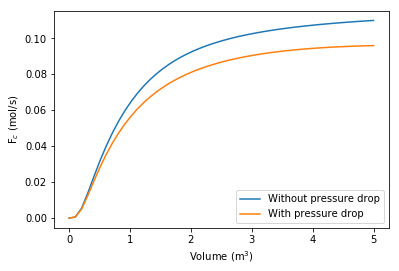

In [5]:
plt.plot(Vspan, Fc,
         Vspan, Fcf)

plt.xlabel('Volume (m$^3$)')
plt.ylabel('F$_c$ (mol/s)')

plt.legend(['Without pressure drop','With pressure drop'])
plt.show()
